In [24]:
import openmc
import matplotlib.pyplot as plt
import numpy as np

In [25]:
umet = openmc.Material()
umet.add_nuclide("U235", 0.9473, 'wo')
umet.add_nuclide("U238", 0.0527, 'wo')
umet.add_nuclide("U234", 0.0102, 'wo')
umet.set_density("g/cm3", 18.74)

mats = openmc.Materials([umet])
mats.cross_sections = "/home/agusgimenez/KD_OPMC/Secciones/endfb-vii.1-hdf5/cross_sections.xml"
mats.export_to_xml()

esfera = openmc.Sphere(r=8.74, boundary_type="vacuum")
godiva = openmc.Cell(region = -esfera, fill=umet)
simulacion = openmc.Universe(cells=[godiva])

geom = openmc.Geometry(simulacion)
geom.export_to_xml()


In [26]:
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <cross_sections>/home/agusgimenez/KD_OPMC/Secciones/endfb-vii.1-hdf5/cross_sections.xml</cross_sections>
  <material depletable="true" id="5">
    <density units="g/cm3" value="18.74" />
    <nuclide name="U235" wo="0.9473" />
    <nuclide name="U238" wo="0.0527" />
    <nuclide name="U234" wo="0.0102" />
  </material>
</materials>


In [27]:
!cat geometry.xml

<?xml version='1.0' encoding='utf-8'?>
<geometry>
  <cell id="5" material="5" region="-5" universe="5" />
  <surface boundary="vacuum" coeffs="0.0 0.0 0.0 8.74" id="5" type="sphere" />
</geometry>


In [28]:
!cat settings.xml

<?xml version='1.0' encoding='utf-8'?>
<settings>
  <run_mode>eigenvalue</run_mode>
  <particles>100000</particles>
  <batches>110</batches>
  <inactive>10</inactive>
</settings>


In [29]:
run = openmc.Settings()
run.run_mode = "eigenvalue"
run.particles = 100000
run.batches = 110
run.inactive = 10
run.export_to_xml()

values = np.logspace(np.log10(1e-5))
Filtro_Energia = openmc.filter.EnergyFilter(values,id = 0)

tally_flujo = openmc.Tally(name = "PHI")
tally_flujo.score = ["flux"]
tally_flujo.

In [30]:
!rm statepoint.110.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [31]:
estado3 = openmc.StatePoint("statepoint.110.h5")
keff3 = estado3.k_generation

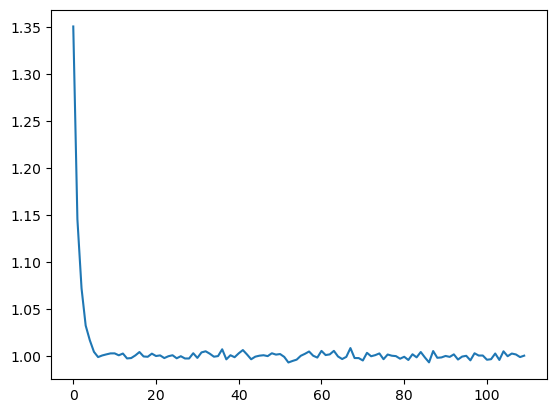

In [32]:
plt.plot(keff3)

El resultado neto es que la incerteza en el factor de multiplicación se reduce en un factor de $1/\sqrt{N}$.

## Simulación de fuente fija

Para realizar un cálculo en modo de fuente externa es necesario definir una fuente. La fuente se especifica en el parámetro `.source` del objeto de clase `Settings`. La fuente es un objeto generado con la función `.Source()`, que posee como atributos las distribuciones espaciales, angulares y energéticas de la fuente. Por ejemplo, para definir una fuente isotrópica de $1$ MeV en el origen hacemos:

In [ ]:
dist_espacial = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))
dist_angular = openmc.stats.Isotropic()
dist_energetica = openmc.stats.Discrete([1.0e6], [1.0])

fuente = openmc.Source()
fuente.space = dist_espacial
fuente.angle = dist_angular
fuente.energy = dist_energetica

parametros = openmc.Settings()
parametros.source = fuente

Las distribuciones se generan en base al módulo `openmc.stats`. Este módulo posee distintos tipos de distribuciones para las variables energía, posición y dirección, y distribuciones de probabilidad genéricas:

Distribuciones espaciales:

* `openmc.stats.Point()`: distribución delta en un punto del espacio, $\delta(\vec{r}-\vec{r}_0)$.
* `openmc.stats.Box()`: distribución uniformemente distribuida entre un punto (esquina inferior izquierda) y otro (esquina superior derecha).
* `openmc.stats.CartesianIndependent()`: distribución factorizada en distribuciones univariadas para $x$, $y$, $z$.

Distribuciones angulares:
* `openmc.stats.Isotropic()`: distribución isotrópica en la esfera unitaria.
* `openmc.stats.Monodirectional()`: distribución delta en una dirección angular, $\delta(\hat{\Omega}-\hat{\Omega}_0)$.
* `openmc.stats.PolarAzimuthal()`: distribución factorizada en distribuciones univariadas para $\mu = \cos(\theta)$ y $\phi$, respecto a una dirección dada (por defecto, $+z$).

Distribuciones univariadas (que pueden utilizarse también para energía):
* `openmc.stats.Discrete()`: distribución caracterizada por valores discretos con probabilidad asociada.
* `openmc.stats.Uniform()`: distribución con probabilidad constante en un intervalo $[a,b]$.
* `openmc.stats.Tabular()`: distribución continua por trozos con una ley de interpolación (histograma, lin-lin, lin-log, log-lin o log-log`).
* `openmc.stats.Watt()`: distribución de Watt (espectro de fisión: $\chi(E) = C e^{-E/a} \sinh{\sqrt{b E}}$).
* `openmc.stats.Maxwell()`: distribución de Maxwell (distribución térmica: $M(E) = C E e^{-E/kT}$)
* `openmc.stats.Legendre()`: distribución de probabilidad dada por una expansión en polinomios de Legendre.
* `openmc.stats.Mixture()`: distribución discreta en la que los valores son otras distribuciones (similar a `FCEL` en MCNP).

Por ejemplo, la fuga de neutrones de una esfera de agua de radio $5$ cm con una fuente monoenergética :

In [ ]:
h2o = openmc.Material()
h2o.add_nuclide("H1", 2.0, "ao")
h2o.add_nuclide("O16", 1.0, "ao")
h2o.set_density("g/cm3", 1)
h2o.add_s_alpha_beta("c_H_in_H2O")

mats = openmc.Materials([h2o])
mats.cross_sections = "/content/nndc_hdf5/cross_sections.xml"
mats.export_to_xml()

esfera = openmc.Sphere(R=5, boundary_type="vacuum")
celda = openmc.Cell(region=-esfera, fill=h2o)
universo = openmc.Universe(cells=[celda])

geom = openmc.Geometry(universo)
geom.export_to_xml()

dist_espacial = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))
dist_angular = openmc.stats.Isotropic()
dist_energetica = openmc.stats.Discrete([1.0e6], [1.0])

fuente = openmc.Source()
fuente.space = dist_espacial
fuente.angle = dist_angular
fuente.energy = dist_energetica

parametros = openmc.Settings()
parametros.source = fuente
parametros.run_mode = "fixed source"
parametros.batches = 100
parametros.particles = 1000
parametros.export_to_xml()

In [ ]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Fuentes distribuidas en cálculos de criticidad

Ahora que sabemos definir fuentes podemos volver a la simulación de Godiva. Como vimos, el estimador del factor de multiplicación estaba sobreestimado en las primeras generaciones porque la fuente inicial estaba concentrada en la región de máxima importancia (el centro de la esfera). Si, por el contrario, ponemos una fuente inicial distribuida en todo el núcleo la aproximación será por abajo:

In [ ]:
umet = openmc.Material()
umet.add_nuclide("U235", 0.9473, 'wo')
umet.add_nuclide("U238", 0.0527, 'wo')
umet.add_nuclide("U234", 0.0102, 'wo')
umet.set_density("g/cm3", 18.74)

mats = openmc.Materials([umet])
mats.cross_sections = "/content/nndc_hdf5/cross_sections.xml"
mats.export_to_xml()

esfera = openmc.Sphere(R=8.74, boundary_type="vacuum")
godiva = openmc.Cell(region = -esfera, fill=umet)
simulacion = openmc.Universe(cells=[godiva])

geom = openmc.Geometry(simulacion)
geom.export_to_xml()

run = openmc.Settings()
run.run_mode = "eigenvalue"
run.particles = 1000
run.batches = 110
run.inactive = 10

fuente = openmc.Source()
dist_espacial = openmc.stats.Box((-9.0, -9.0, -9.0), (+9.0, +9.0, +9.0), only_fissionable=True)
dist_angular = openmc.stats.Isotropic()
fuente.space = dist_espacial
fuente.angle = dist_angular

run.source = fuente

run.export_to_xml()

In [ ]:
!rm statepoint.110.h5
!rm summary.h5
openmc.run()

rm: cannot remove 'statepoint.110.h5': No such file or directory

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%

0

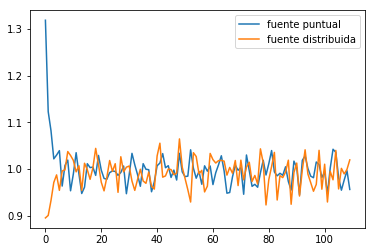

In [ ]:
estado4 = openmc.StatePoint("statepoint.110.h5")
keff4 = estado4.k_generation
plot(keff, label="fuente puntual")
plot(keff4, label="fuente distribuida")
legend()